In [1]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer




/Users/mohanthota/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Exploring Shakespeare's Plays with PCA 

In this problem, I used Principal Components Analysis to examine Shakespeare's plays, just as we discussed a similar technique with a different play or movie in one of our previous lectures. Throughout the process, I made use of the tokenizer and the TF-IDF vectorizer from the sklearn library, a widely used machine learning tool.

I also made a note that there exists a text analysis library called Torchtext in PyTorch. However, in my perspective, this library appears to be less well-developed and less well-supported compared to the other functionalities of PyTorch. Therefore, I opted to utilize sklearn for this particular problem.

Part A

In [2]:
plays_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv').to_numpy()

player_genders_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv').to_numpy()

play_attributes_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv').to_numpy()



import pandas as pd
import numpy as np

print("Plays Array:")
print("Shape:", plays_array.shape)
print("First Line:", plays_array[0])

print("\nPlayer Genders Array:");print("Shape:", player_genders_array.shape)
print("First Line:", player_genders_array[0]);print("\nPlay Attributes Array:")
print("Shape:", play_attributes_array.shape)
print("First Line:", play_attributes_array[0])



Plays Array:
Shape: (111582, 4)
First Line: [1 'Henry IV Part 1' '<Stage Direction>' 'ACT I']

Player Genders Array:
Shape: (398, 2)
First Line: ['AARON' 'male']

Play Attributes Array:
Shape: (36, 3)
First Line: ['Henry IV Part 1' 'History' 15]


### Part B: Visualizing the Plays 
1. I created an array consisting of 36 strings, each of which was formed by concatenating all lines spoken in the respective play. It was crucial to exclude stage directions during this process, and I found it helpful to establish an appropriate dictionary as an intermediary step.

2. To construct a document-term matrix, I set up a structure where each row represented a play, and each column represented a term (word) used in that play. The matrix entries denoted the frequency of a particular word (determined by the column) occurring in a specific play (defined by the row). I leveraged the `CountVectorizer` from `sklearn` to generate this matrix while ensuring that the row order matched that of the original files, preserving the association between play names and terms.

3. Using the matrix obtained in the previous step, I employed the `TruncatedSVD` technique from `sklearn` to create a 2-dimensional representation for each play. My objective was to make the visual representation resemble a specific illustration, which entailed providing suitable titles, listing the play names along with their chronological order, and assigning distinct colors to different genres. For optimal visibility, I adjusted the `figsize` to `(8,8)` and set the `fontsize` to `6`. I followed a tutorial for guidance, particularly focusing on the "PCA" section.

4. I repeated the entire process, but this time, I utilized TF-IDF counts by employing the `TFIDFVectorizer` from `sklearn`.

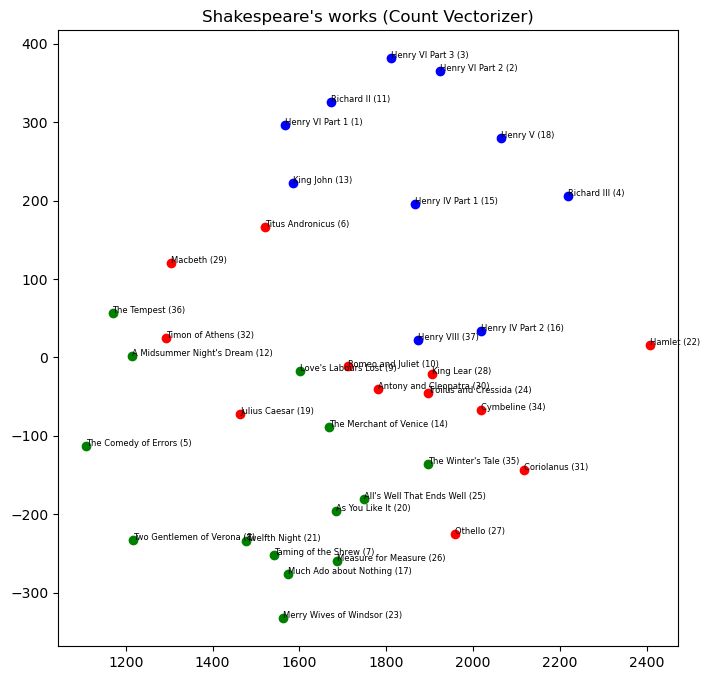

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
aggregated_plays = {}
for entry in plays_array:
    play, actor, text = entry[1], entry[2], entry[3]
    if actor != "<Stage Direction>":
        aggregated_plays[play] = aggregated_plays.get(play, "") + " " + text

plays_text = list(aggregated_plays.values())

X_vec = CountVectorizer().fit_transform(plays_text);X_reduced = TruncatedSVD(n_components=2).fit_transform(X_vec)
genres_list = play_attributes_array[:, 1]
order_list = play_attributes_array[:, 2]
plt.figure(figsize=(8, 8))
colors = {"Comedy": "green", "Tragedy": "red", "History": "blue"}
for idx, (a, b) in enumerate(X_reduced):
    plt.scatter(a, b, color=colors[genres_list[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({order_list[idx]})", (a, b), fontsize=6)

plt.title("Shakespeare's works (Count Vectorizer)")
plt.show()


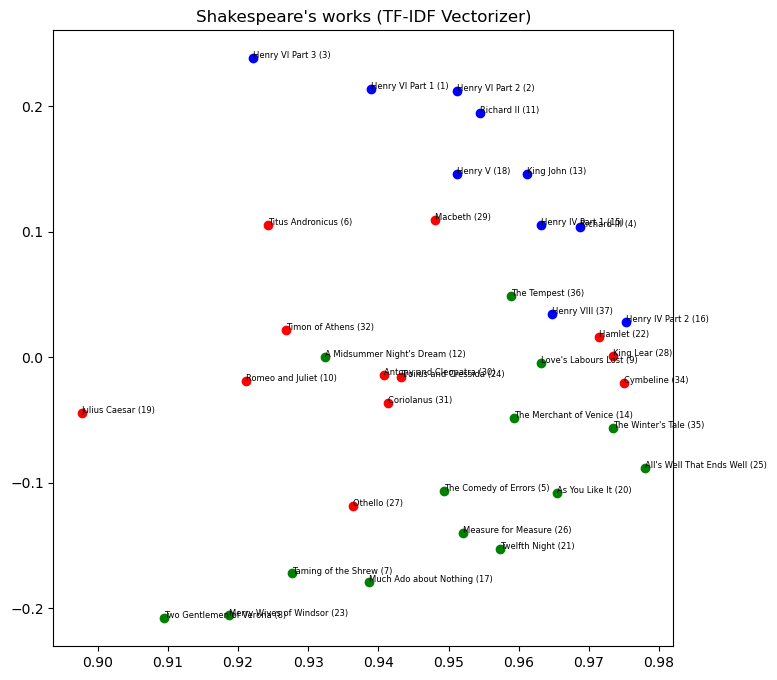

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

tfidf_vec = TfidfVectorizer();X_tfidf_transformed = tfidf_vec.fit_transform(plays_text)
svd = TruncatedSVD(n_components=2);X_reduced_tfidf = svd.fit_transform(X_tfidf_transformed)
plt.figure(figsize=(8, 8))
for idx, (a, b) in enumerate(X_reduced_tfidf):
    plt.scatter(a, b, color=colors[genres_list[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({order_list[idx]})", (a, b), fontsize=6)

plt.title("Shakespeare's works (TF-IDF Vectorizer)")
plt.show()


Observations

1. **Similar Plays**:
From tf-idf, "Henry VI Part 3", "Henry VI Part 2", and "Henry VI Part 1" are close to each other. Similarly, "The Tempest", "King Henry VIII", "Hamlet", and "King Lear" .
From counter Vectorizer, "Titus Andronicus", "Macbeth", and "The Tempest" are close, while "Romeo and Juliet", "King Lear", and "Hamlet" also cluster together. hmm interesting.... made me retink for a second .

2. **Match with Shakespeare's Groupings**:
the genres are collided in counter vectorizer . in TF IDF it have not done best job but compared to first graph it have observed the genres .
3. **Outliers**:
    In the TF-IDF representation, "Two Gentlemen of Verona", "Taming of the Shrew", and "Much Ado about Nothing" appear to be outliers in the comedy genre, while "Julius Caesar" is an outlier for the tragedies.
 from Count Vectorizer , "Two Gentlemen of Verona" remains an outlier for the comedies, and plays like "The Comedy of Errors" and "Merry Wives of Windsor" also appear distant from others in their respective genres. i did some background check on these with curosity .

4. **TF vs TF-IDF**:
  TF-IDF did a better job because the grouping was better than the first graph in terms of close clustering


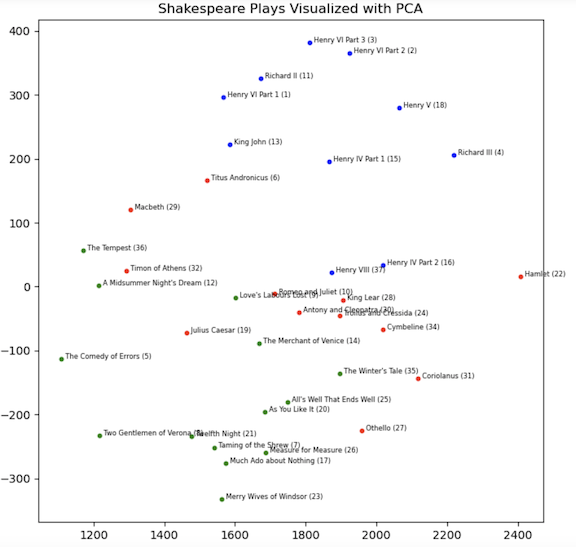

### Part C: Visualizing the Players

I repeated a similar visualization process, but this time, my focus was on visualizing players instead of plays. The initial steps remained largely unchanged, beginning with the creation of an array of strings representing the lines spoken by each player. I had the option to use either TF or TF-IDF for this task.

To enhance visibility, I adjusted the figsize to (8,8) and set the fontsize to 4. Additionally, I ensured that different colors were used to distinguish between genders within the visualizations.


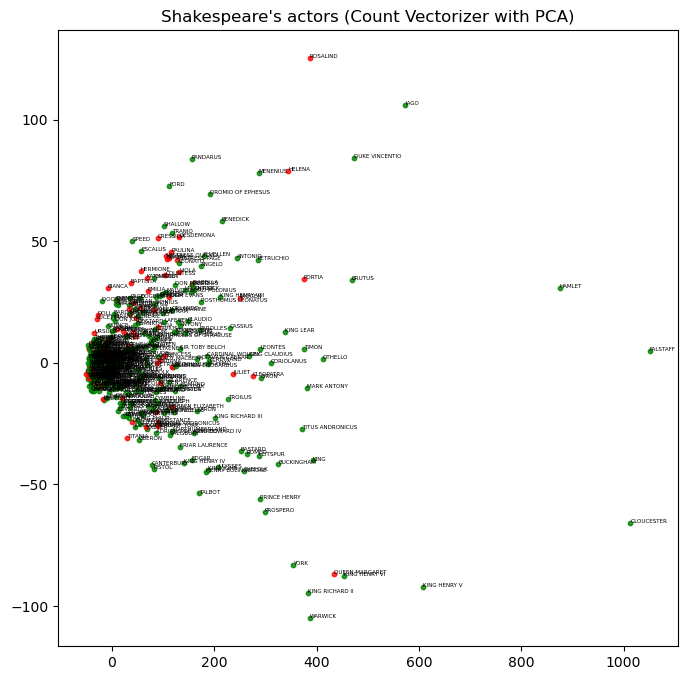

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

player_lines = {}
for entry in plays_array:
    play, actor, text = entry[1], entry[2], entry[3]
    if actor != "<Stage Direction>":
        player_lines[actor] = player_lines.get(actor, "") + " " + text

lines_by_actor = list(player_lines.values())

X_vectorized = CountVectorizer().fit_transform(lines_by_actor)
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_vectorized.toarray())
actor_genders = [dict(player_genders_array).get(actor, "Unknown") for actor in player_lines.keys()]

plt.figure(figsize=(8, 8))
colors = {"male": "green", "female": "red"}

for idx, (a, b) in enumerate(X_pca):
    actor_gender = actor_genders[idx]
    if actor_gender != "Unknown":
        plt.scatter(a, b, color=colors[actor_gender], alpha=0.8, s=10)
        plt.annotate(list(player_lines.keys())[idx], (a, b), fontsize=4, alpha=1)

plt.title("Shakespeare's actors (Count Vectorizer with PCA)")
plt.show()


Observations 

i see that , may be, that most charectors have used similar words and yes precisely short sentences . talking about outliers some of them are main charectors as per my knowledge so they might be distinct from normal charectors . again interesting to see the dense cluster 

### Part D:  DIY Word Embeddings 

In this part, I created a word-word matrix where each row and column represented a word in the vocabulary. The entries in this matrix indicated the number of times a particular word co-occurred with another word in the same sentence within the plays. To accomplish this, I followed these steps:

1. **Punctuation Removal**: I began by removing punctuation marks such as periods, commas, semicolons, colons, question marks, and exclamation marks, while preserving single quotes.

2. **Nested Dictionary Creation**: I constructed a nested dictionary structure, where each word mapped to a dictionary containing the frequency of other words that co-occurred in the same line or sentence. This process helped establish relationships between words based on their co-occurrence patterns.

3. **Sparse Matrix Generation**: From the nested dictionary, I generated a sparse matrix representing word co-occurrence frequencies. This matrix served as the foundation for creating the average document-term matrix, which would be used as input for the `TruncatedSVD` dimensionality reduction technique.

4. **Vocabulary Reduction (Optional)**: To manage memory constraints, I considered eliminating "stop words" and selecting a limited number (e.g., 5000) of the most common remaining words. This reduced vocabulary was used to build the visualization, ensuring computational feasibility.

Ultimately, the goal was to visualize plays using `TruncatedSVD` as I had done previously, while leveraging either TF or TF-IDF representations of the text data. This approach aimed to capture semantic relationships between words and their roles in plays, providing insights into how plays were structured and written.


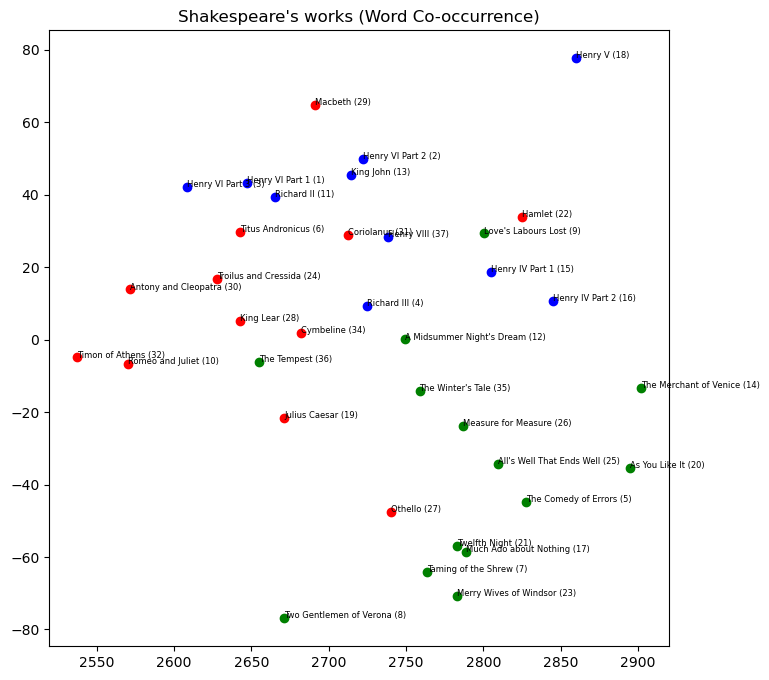

In [6]:
import numpy as np
import re
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix
def clean_line(line):
    return re.sub(r'[.,;:?!]', '', line).lower().split()

plays_to_lines = defaultdict(list)
for entry in plays_array:
    play, text = entry[1], entry[3]
    if text != "<Stage Direction>":
        plays_to_lines[play].append(clean_line(text))
word_count = Counter(word for play_lines in plays_to_lines.values() for line in play_lines for word in line);dictionary = {word: idx for idx, (word, _) in enumerate(word_count.most_common(5000))}

word_cooccurrence = defaultdict(Counter)
for play_lines in plays_to_lines.values():
    for line in play_lines:
        unique_words = set(word for word in line if word in dictionary)
        for word in unique_words:
            word_cooccurrence[word].update(unique_words)

i_vals, j_vals, freqs = [], [], []
for word, related_words in word_cooccurrence.items():
    for related, frequency in related_words.items():
        if word != related:
            i_vals.append(dictionary[word])
            j_vals.append(dictionary[related])
            freqs.append(frequency)

matrix = csr_matrix((freqs, (i_vals, j_vals)), shape=(len(dictionary), len(dictionary)));genres = play_attributes_array[:, 1];play_order = play_attributes_array[:, 2]


play_representations = []
for play, play_lines in plays_to_lines.items():
    play_vec = np.zeros(len(dictionary))
    total_words = 0
    for line in play_lines:
        for word in line:
            if word in dictionary:
                play_vec += matrix[dictionary[word]].toarray()[0]
                total_words += 1
    if total_words:
        play_vec /= total_words
    play_representations.append(play_vec)

final_matrix = np.vstack(play_representations)
X_2d_representation = svd.fit_transform(final_matrix)
color_map = {"Comedy": "green", "Tragedy": "red", "History": "blue"}

plt.figure(figsize=(8, 8))
for idx, (a, b) in enumerate(X_2d_representation):
    plt.scatter(a, b, color=color_map[genres[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({play_order[idx]})", (a, b), fontsize=6)

plt.title("Shakespeare's works (Word Co-occurrence)")
plt.show()


Observations

this visualization gives us  different perspective Compared to the first visualization . think that it is giving us more infromation than the first one becuase this is based on word co occurances rather than just counting words

### Part E:  Visualizing the Plays using Word2Vec Word Embeddings
In this part, I visualized the plays using word embeddings created with Gensim's Word2Vec, which employs more advanced algorithms for generating word embeddings compared to the previous approach. I followed these steps:

1. **Word2Vec Model Creation**: I created Word2Vec embeddings by following the guidelines provided in the Gensim documentation. It involved experimenting with hyperparameters such as the window size and min_count to optimize the quality of the word embeddings.

2. **KeyedVectors Usage**: To enhance efficiency, I used Gensim's KeyedVectors to avoid recomputing the word embeddings model each time. This significantly sped up the process, especially for large corpora.

3. **Visualization with PCA**: Unlike the previous visualization using TruncatedSVD, I opted for Principal Component Analysis (PCA) to visualize the plays. PCA provided a different perspective on the data and allowed me to observe patterns and relationships among the plays based on Word2Vec word embeddings.

4. **TF or TF-IDF**: I chose either the Term Frequency (TF) or Term Frequency-Inverse Document Frequency (TF-IDF) representation of the text data as the basis for creating the visualization. This decision impacted the weighting of word importance in the embeddings and influenced the overall structure of the visualization.

This approach aimed to uncover insights into the relationships between words used in Shakespeare's plays and provide a unique perspective on their content and composition. By leveraging Word2Vec embeddings and PCA, I explored a different dimension of textual analysis, shedding light on semantic connections within the plays.

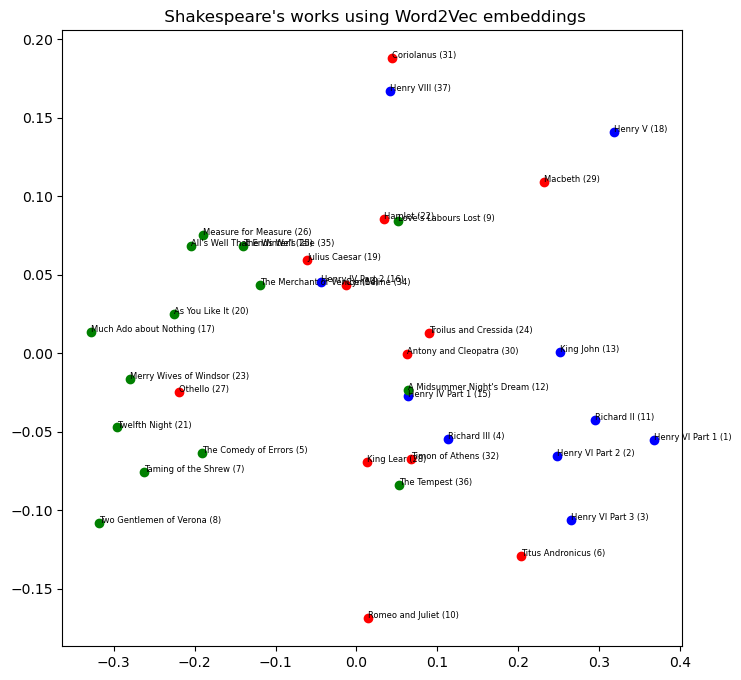

In [7]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

text_data = [sentence for sentences in plays_to_lines.values() for sentence in sentences]

w2v_model = Word2Vec(sentences=text_data, window=5, min_count=3, workers=4)
w2v_model.save("word2vec_embedding.model")

word_embeds = w2v_model.wv

avg_play_vectors = []
for play, sentences in plays_to_lines.items():
    vector_sum = np.zeros(w2v_model.vector_size)
    total_words = 0
    for sentence in sentences:
        for word in sentence:
            if word in word_embeds:
                vector_sum += word_embeds[word]
                total_words += 1
    if total_words:
        vector_sum /= total_words
    avg_play_vectors.append(vector_sum)

combined_play_vectors = np.vstack(avg_play_vectors);reduced_vectors = PCA(n_components=2).fit_transform(combined_play_vectors)

plt.figure(figsize=(8, 8))
for idx, (a, b) in enumerate(reduced_vectors):
    plt.scatter(a, b, color=color_map[genres[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({play_order[idx]})", (a, b), fontsize=6)

plt.title(" Shakespeare's works using Word2Vec embeddings")
plt.show()


Observations

it shows how closely related the plays are in terms of themes and meanings. Unlike earlier visuals, it is giving us based on the overall message of the plays rather than just the words used.|


### Part F:  Visualizing the Players using Word2Vec Word Embeddings 

In this part, I repeated the visualization process for the players, utilizing Word2Vec embeddings generated with Gensim's Word2Vec model. The steps were as follows:

1. **Word2Vec Model**: I employed Gensim's Word2Vec to create word embeddings for the player lines. This approach utilized advanced algorithms for word embedding generation, providing more contextually meaningful representations of words.

2. **Data Representation**: I represented the player lines using either Term Frequency (TF) or Term Frequency-Inverse Document Frequency (TF-IDF) to capture word importance based on their frequency in the text data.

3. **Visualization with PCA**: To visualize the players, I applied Principal Component Analysis (PCA). This allowed me to reduce the dimensionality of the data and create a clear visual representation of the players based on their Word2Vec embeddings.

4. **Visual Presentation**: I configured the figure size to (8,8) and set the font size to 4 to ensure that the visualization was both visually appealing and informative.

This approach aimed to provide insights into the relationships between players based on their dialogue in Shakespeare's plays. By utilizing Word2Vec embeddings and PCA, I explored how players' language patterns related to one another, offering a novel perspective on the characters' interactions and roles in the plays.

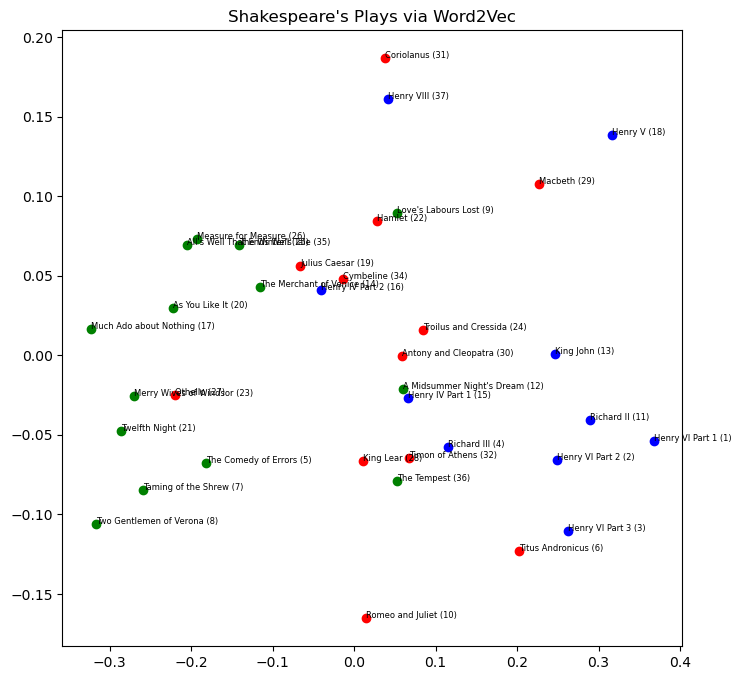

In [8]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
training_data = [sentence for group_sentences in plays_to_lines.values() for sentence in group_sentences]
w2v = Word2Vec(sentences=training_data, window=5, min_count=3, workers=4)
w2v.save("word_embeddings.model")

embeddings = w2v.wv

averaged_vectors = []
for play_title, sentences in plays_to_lines.items():
    accumulated_vector = np.zeros(w2v.vector_size)
    total_terms = 0
    for sentence in sentences:
        for term in sentence:
            if term in embeddings:
                accumulated_vector += embeddings[term]
                total_terms += 1
    if total_terms:
        accumulated_vector /= total_terms
    averaged_vectors.append(accumulated_vector)

matrix_representation = np.vstack(averaged_vectors);reduced_data = PCA(n_components=2).fit_transform(matrix_representation)

plt.figure(figsize=(8, 8))
for idx, (horizontal, vertical) in enumerate(reduced_data):
    plt.scatter(horizontal, vertical, color=color_map[genres[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({play_order[idx]})", (horizontal, vertical), fontsize=6)

plt.title("Shakespeare's Plays via Word2Vec")
plt.show()


Observations 

Hmm...again interesting and i was expecting something like this. this visualization is not as denser as the one in C. plus this is grouping based on similarities rather than jus the words . so each play might be similar to each other based on words they use.